In [76]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Analysis imports
from pandas.plotting import lag_plot
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import DataFrame
from pandas import concat

# Modelling imports
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, RNN
from keras.layers import Dropout

input data of ABBANK

In [77]:
df = pd.read_csv('/content/Data_SQURPHARMA.csv')
df.head()

,date,last_traded_price,high,low,opening_price,closing_price,trade,value_mn,volume,month,day_of_month,day_of_year,day_of_week,difference
0,2012-12-30,168.0,169.4,168.0,169.4,168.6,1060,25.6366,152110,12,30,365,6,1.4
1,2012-12-27,168.0,169.5,167.9,169.5,168.1,1149,21.1182,125380,12,27,362,3,1.6
2,2012-12-26,169.0,170.0,168.0,169.9,168.3,698,17.6708,104880,12,26,361,2,2.0
3,2012-12-24,168.9,169.9,167.9,169.0,168.4,869,14.5961,86590,12,24,359,0,2.0
4,2012-12-23,169.0,170.7,168.1,169.2,168.8,1055,19.9893,117940,12,23,358,6,2.6


In [78]:

df.index  = df['date']
df

,date,last_traded_price,high,low,opening_price,closing_price,trade,value_mn,volume,month,day_of_month,day_of_year,day_of_week,difference
date,,,,,,,,,,,,,,
2012-12-30,2012-12-30,168.0,169.4,168.0,169.4,168.6,1060,25.6366,152110,12,30,365,6,1.4
2012-12-27,2012-12-27,168.0,169.5,167.9,169.5,168.1,1149,21.1182,125380,12,27,362,3,1.6
2012-12-26,2012-12-26,169.0,170.0,168.0,169.9,168.3,698,17.6708,104880,12,26,361,2,2.0
2012-12-24,2012-12-24,168.9,169.9,167.9,169.0,168.4,869,14.5961,86590,12,24,359,0,2.0
2012-12-23,2012-12-23,169.0,170.7,168.1,169.2,168.8,1055,19.9893,117940,12,23,358,6,2.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-07,2019-01-07,256.4,259.4,255.6,258.8,256.8,1998,115.6590,450176,1,7,7,0,3.8
2019-01-06,2019-01-06,257.5,258.9,254.9,255.0,257.9,2009,88.7110,344774,1,6,6,6,4.0
2019-01-03,2019-01-03,255.0,255.7,252.9,254.0,254.8,1945,113.3780,446554,1,3,3,3,2.8


Take closing_price for prediction

In [79]:
values = DataFrame(df['closing_price'].values)
dataframe = concat([values.shift(1),values.shift(5),values.shift(10),values.shift(30), values], axis=1)
dataframe.columns = ['t', 't+1', 't+5', 't+10', 't+30']
result = dataframe.corr()
print(result)

             t       t+1       t+5      t+10      t+30
t     1.000000  0.921813  0.870769  0.691444  0.953999
t+1   0.921813  1.000000  0.910886  0.722114  0.910858
t+5   0.870769  0.910886  1.000000  0.766626  0.861052
t+10  0.691444  0.722114  0.766626  1.000000  0.683993
t+30  0.953999  0.910858  0.861052  0.683993  1.000000


Split train and test data

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


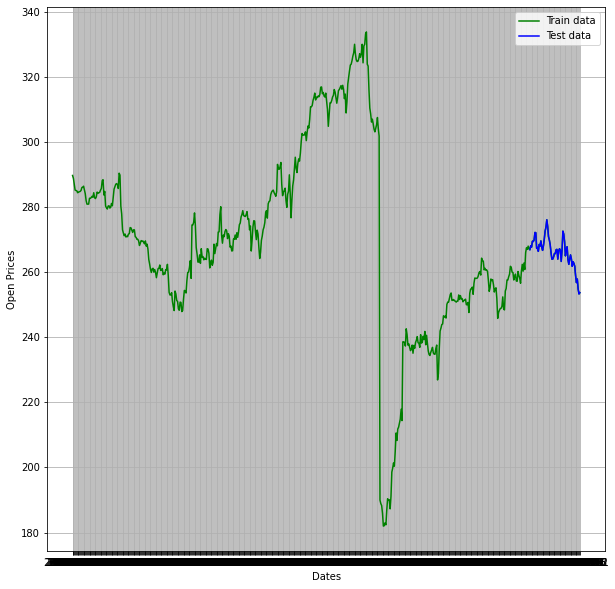

In [80]:
train_data, test_data = df[0:-60], df[-60:]
plt.figure(figsize=(10,10))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(df['closing_price'].tail(600), 'green', label='Train data')
plt.plot(test_data['closing_price'], 'blue', label='Test data')
plt.legend()

Show the closing_price column data

In [81]:
df['closing_price']

date
2012-12-30    168.6
2012-12-27    168.1
2012-12-26    168.3
2012-12-24    168.4
2012-12-23    168.8
              ...  
2019-01-07    256.8
2019-01-06    257.9
2019-01-03    254.8
2019-01-02    253.3
2019-01-01    253.7
Name: closing_price, Length: 1926, dtype: float64

We take 60 days data to test our models

In [82]:
test_data.shape

(60, 14)

In [83]:
train_data.closing_price.tail(30) 

date
2019-05-15    248.4
2019-05-14    254.2
2019-05-13    255.0
2019-05-12    257.6
2019-05-09    257.6
2019-05-08    258.6
2019-05-07    259.4
2019-05-06    261.8
2019-05-05    261.5
2019-05-02    260.0
2019-04-30    259.9
2019-04-29    257.6
2019-04-28    258.6
2019-04-25    259.4
2019-04-24    257.3
2019-04-23    257.2
2019-04-21    260.2
2019-04-18    259.0
2019-04-17    258.2
2019-04-16    256.6
2019-04-15    260.3
2019-04-11    262.4
2019-04-10    260.3
2019-04-09    262.8
2019-04-08    260.8
2019-04-07    266.0
2019-04-04    267.5
2019-04-03    267.0
2019-04-02    268.0
2019-04-01    267.1
Name: closing_price, dtype: float64

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

MSE: 272.94546692578984
MAE: 15.839517133956484
RMSE: 16.521061313541267


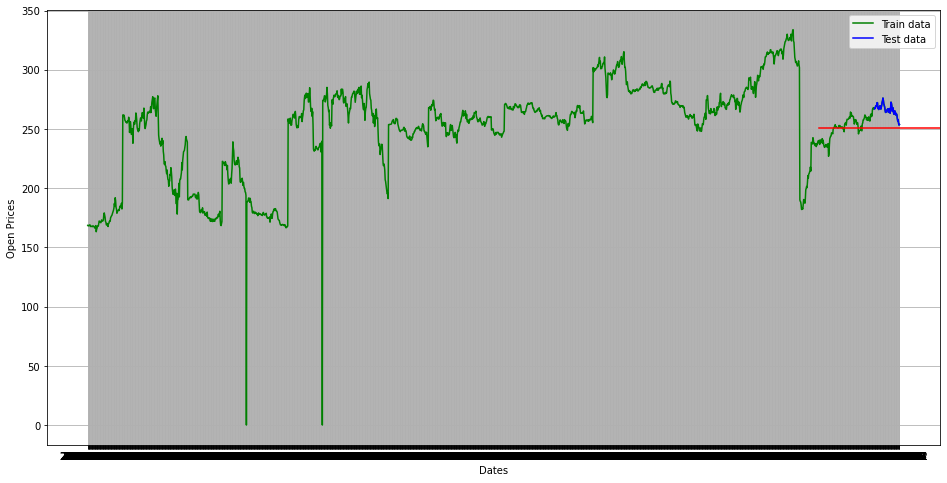

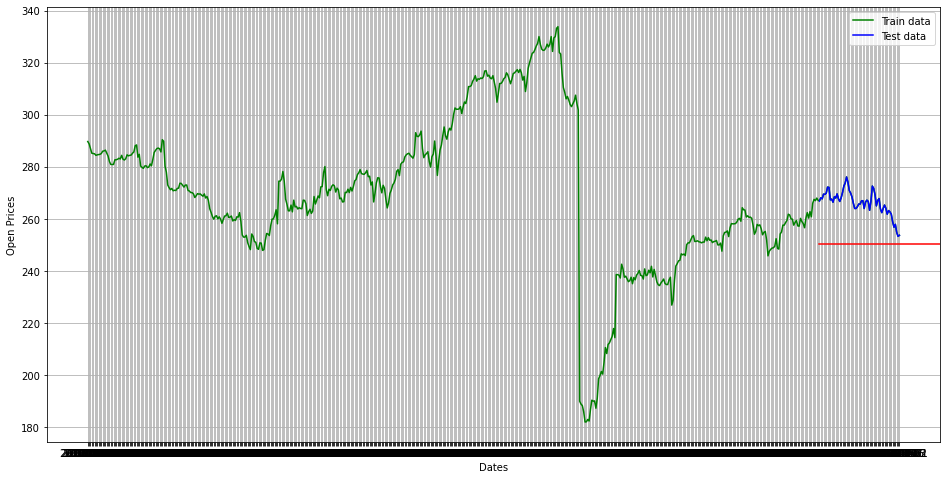

In [84]:
mean_value = df['closing_price'].mean() # calculation of mean price

plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(df['closing_price'], 'green', label='Train data')
plt.plot(test_data['closing_price'], 'blue', label='Test data')
plt.axhline(y=mean_value, xmin=0.864, xmax=1, color='red')
plt.legend()

plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(df['closing_price'].tail(600), 'green', label='Train data')
plt.plot(test_data['closing_price'], 'blue', label='Test data')
plt.axhline(y=mean_value, xmin=0.864, xmax=1, color='red')
plt.legend()

print('MSE: '+str(mean_squared_error(test_data['closing_price'], np.full(len(test_data), mean_value))))
print('MAE: '+str(mean_absolute_error(test_data['closing_price'], np.full(len(test_data), mean_value))))
print('RMSE: '+str(sqrt(mean_squared_error(test_data['closing_price'], np.full(len(test_data), mean_value)))))

Train data for ARIMA model

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

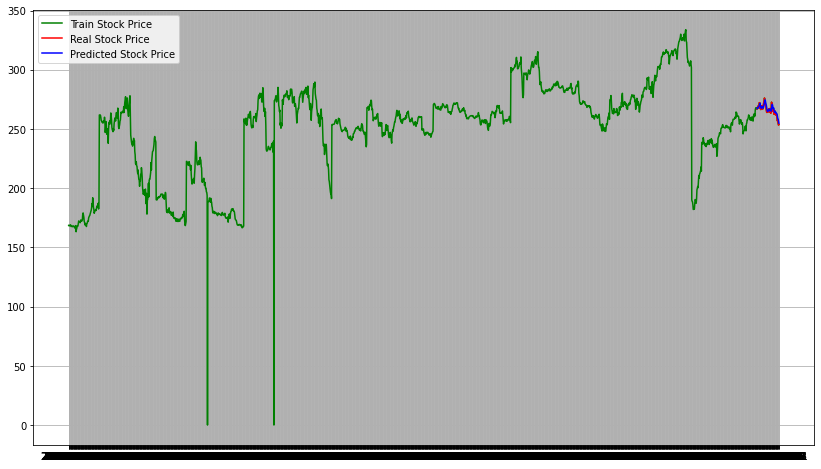

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

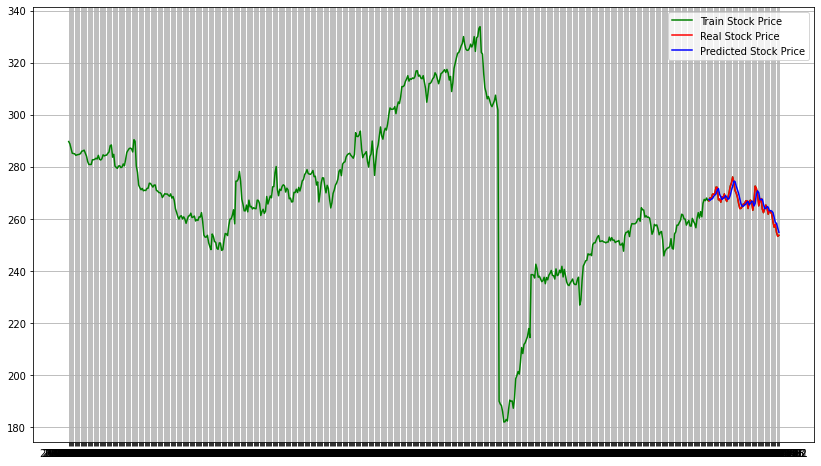

MSE: 5.624051689902766
MAE: 1.8823297995859405
RMSE: 2.3715083153771075


In [85]:
train_arima = train_data['closing_price']
test_arima = test_data['closing_price']

history = [x for x in train_arima]
y = test_arima
# make first prediction
predictions = list()
model = ARIMA(history, order=(1,1,0))
model_fit = model.fit(disp=0)
yhat = model_fit.forecast()[0]
predictions.append(yhat)
history.append(y[0])
# rolling forecasts
for i in range(1, len(y)):
    # predict
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    # invert transformed prediction
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)
    
plt.figure(figsize=(14,8))
plt.plot(df.index, df['closing_price'], color='green', label = 'Train Stock Price')
plt.plot(test_data.index, y, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predictions, color = 'blue', label = 'Predicted Stock Price')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14,8))
plt.plot(df.index[-600:], df['closing_price'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, y, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predictions, color = 'blue', label = 'Predicted Stock Price')
plt.legend()
plt.grid(True)
plt.show()

print('MSE: '+str(mean_squared_error(y, predictions)))
print('MAE: '+str(mean_absolute_error(y, predictions)))
print('RMSE: '+str(sqrt(mean_squared_error(y, predictions))))

In [86]:
test_data.reset_index(drop=True, inplace=True)

Predicted result for ARIMA model

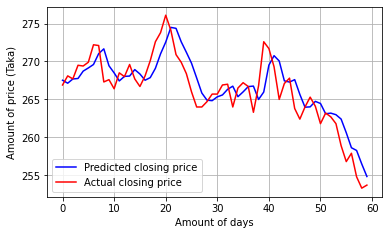

In [87]:
#y_test = df.iloc[int(7200): ,0:1].values
plt.figure(figsize=(6,3.5))
#plt.suptitle('Sine and cosine waves', fontsize=13)
plt.plot(predictions, color='blue', label='Predicted closing price')
plt.plot(test_data['closing_price'], color ='red', label='Actual closing price')
plt.xlabel('Amount of days', fontsize=10)
plt.ylabel('Amount of price (Taka)', fontsize=10)
#plt.xticks(rotation=0,fontsize=12)
#plt.yticks(rotation=0,fontsize=12)
plt.grid(True)
#plt.savefig('ARIMA_Close_Price.jpeg')
plt.legend()
plt.show()

Pre-process data for Prophet model

In [88]:
ph_df_train = train_data.drop(['last_traded_price', 'high', 'low','opening_price',
                               'trade','value_mn','volume','month','day_of_month',
                               'day_of_year','day_of_week','difference'], axis=1)
ph_df_train['date'] = ph_df_train.index
ph_df_train.rename(columns={'closing_price': 'y', 'date': 'ds'}, inplace=True)

prop = Prophet(changepoint_prior_scale=0.1)
prop.fit(ph_df_train)
# Create Future dates
future_prices = prop.make_future_dataframe(periods=73)

# Predict Prices
forecast = prop.predict(future_prices)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [89]:
forecast['yhat']

0       205.525304
1       206.207915
2       206.801443
3       207.773956
4       209.363953
           ...    
1933    222.043279
1934    221.422995
1935    220.745668
1936    220.492633
1937    220.914493
Name: yhat, Length: 1938, dtype: float64

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


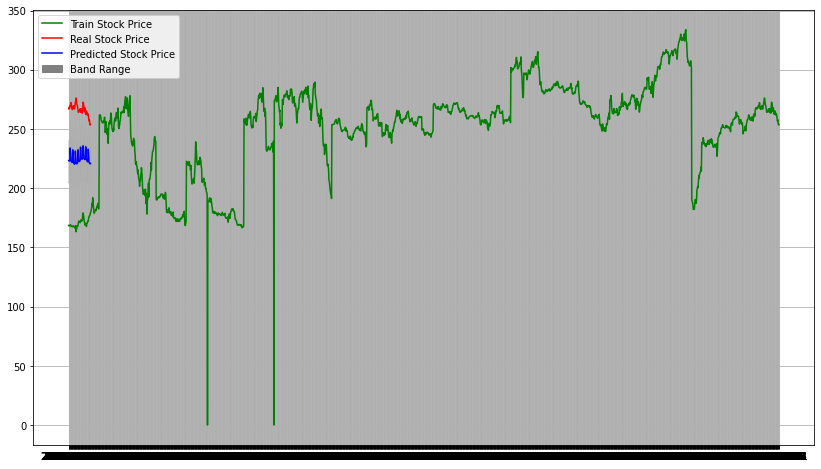

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


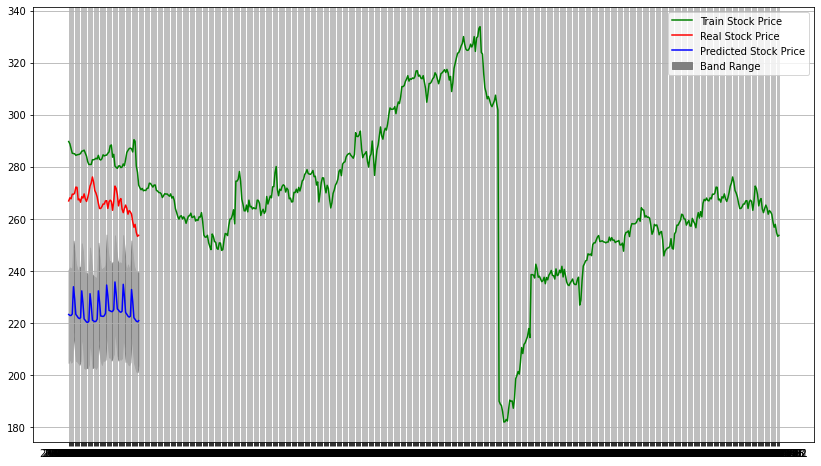

MSE: 1746.6126524523936
MAE: 41.37127299663751
RMSE: 41.79249516901801


In [90]:
plt.figure(figsize=(14,8))
plt.plot(df.index, df['closing_price'], color='green', label = 'Train Stock Price')
plt.plot(test_data.index, test_data['closing_price'], color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, forecast['yhat'][-60:], color = 'blue', label = 'Predicted Stock Price')
plt.fill_between(test_data.index, forecast['yhat_lower'][-60:], forecast['yhat_upper'][-60:], color='grey', label="Band Range")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14,8))
plt.plot(df.index[-600:], df['closing_price'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, test_data['closing_price'], color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, forecast['yhat'][-60:], color = 'blue', label = 'Predicted Stock Price')
plt.fill_between(test_data.index, forecast['yhat_lower'][-60:], forecast['yhat_upper'][-60:], color='grey', label="Band Range")
plt.legend()
plt.grid(True)
plt.show()
print('MSE: '+str(mean_squared_error(test_data['closing_price'], forecast['yhat'][-60:])))
print('MAE: '+str(mean_absolute_error(test_data['closing_price'], forecast['yhat'][-60:])))
print('RMSE: '+str(sqrt(mean_squared_error(test_data['closing_price'], forecast['yhat'][-60:]))))

In [91]:
train = train_data.iloc[:, 1:2].values # selecting open prices
# Feature Scaling
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train) 
# Train dataset
timesteps = 7
X_train = []
y_train = []
for i in range(timesteps, train.shape[0]):
    X_train.append(train_scaled[i-timesteps:i, 0]) # we take 30 previous prices
    y_train.append(train_scaled[i, 0]) # and 60-th price as y value
X_train, y_train = np.array(X_train), np.array(y_train)
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
from numpy.random import seed
seed(2019)

LSTM model training

In [92]:
model = Sequential()

# Adding the first LSTM layer 
# Here return_sequences=True means whether to return the last output in the output sequence, or the full sequence.
# it basically tells us that there is another(or more) LSTM layer ahead in the network.
model.add(LSTM(units = 60, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# Dropout regularisation for tackling overfitting
#model.add(Dropout(0.2))

model.add(LSTM(units = 50))
#model.add(Dropout(0.25))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
# RMSprop is a recommended optimizer as per keras documentation
# check out https://keras.io/optimizers/ for more details
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 100, batch_size = 16)

Epoch 1/100
117/117 [==============================] - 5s 9ms/step - loss: 0.0369
Epoch 2/100
117/117 [==============================] - 1s 9ms/step - loss: 0.0040
Epoch 3/100
117/117 [==============================] - 1s 8ms/step - loss: 0.0039
Epoch 4/100
117/117 [==============================] - 1s 9ms/step - loss: 0.0038
Epoch 5/100
117/117 [==============================] - 1s 8ms/step - loss: 0.0039
Epoch 6/100
117/117 [==============================] - 1s 9ms/step - loss: 0.0039
Epoch 7/100
117/117 [==============================] - 1s 9ms/step - loss: 0.0038
Epoch 8/100
117/117 [==============================] - 1s 8ms/step - loss: 0.0038
Epoch 9/100
117/117 [==============================] - 1s 9ms/step - loss: 0.0039
Epoch 10/100
117/117 [==============================] - 1s 9ms/step - loss: 0.0040
Epoch 11/100
117/117 [==============================] - 1s 8ms/step - loss: 0.0037
Epoch 12/100
117/117 [==============================] - 1s 9ms/step - loss: 0.0037
Epoch 13/100


In [93]:
# this will be used later while comparing and visualization
real_stock_price = test_data.iloc[:,1:2].values # taking open price
# combine original train and test data vertically
# as previous Open Prices are not present in test dataset
# e.g. for predicting Open price for first date in test data, we will need stock open prices on timesteps previous dates  
combine = pd.concat((train_data['closing_price'], test_data['closing_price']), axis = 0)
# our test inputs also contains stock open Prices of last timesteps dates (as described above)
test_inputs = combine[len(combine) - len(test_data) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)
# same steps as we followed while processing training data
X_test = []
for i in range(timesteps, test_data.shape[0]+timesteps):
    X_test.append(test_inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
# inverse_transform because prediction is done on scaled inputs
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

Predicted result for LSTM model

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


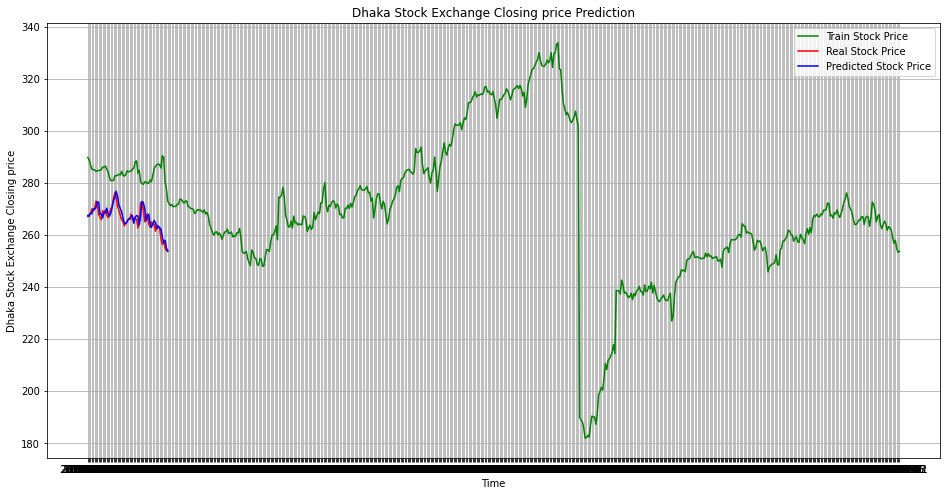

MSE: 4.6131144502096175
MAE: 1.6976139831542971
RMSE: 2.1478162049415723


In [94]:
plt.figure(figsize=(16,8))
plt.plot(df.index[-600:], df['closing_price'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Dhaka Stock Exchange Closing price Prediction')
plt.xlabel('Time')
plt.ylabel('Dhaka Stock Exchange Closing price')
plt.legend()
plt.grid(True)
#plt.savefig('lstm_30.pdf')
plt.show()

mse = mean_squared_error(real_stock_price, predicted_stock_price)
print('MSE: '+str(mse))
mae = mean_absolute_error(real_stock_price, predicted_stock_price)
print('MAE: '+str(mae))
rmse = sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print('RMSE: '+str(rmse))

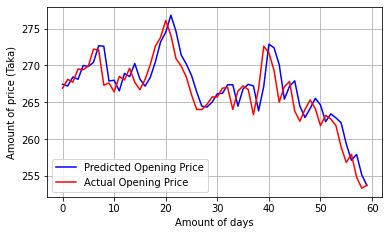

In [95]:
test_data.reset_index(drop=True, inplace=True)
#y_test = df.iloc[int(7200): ,0:1].values
plt.figure(figsize=(6,3.5))
#plt.suptitle('Sine and cosine waves', fontsize=13)
plt.plot(predicted_stock_price, color='blue', label='Predicted Opening Price')
plt.plot(test_data['closing_price'], color ='red', label='Actual Opening Price')
plt.xlabel('Amount of days', fontsize=10)
plt.ylabel('Amount of price (Taka)', fontsize=10)
#plt.xticks(rotation=0,fontsize=12)
#plt.yticks(rotation=0,fontsize=12)
plt.grid(True)
#plt.savefig('LSTM_opening_price.jpeg')
plt.legend()
plt.show()

Training data by GRU model

In [96]:
model = Sequential()

# Adding the first GRU layer 
# Here return_sequences=True means whether to return the last output in the output sequence, or the full sequence.
# it basically tells us that there is another(or more) GRU layer ahead in the network.
model.add(GRU(units = 60, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# Dropout regularisation for tackling overfitting
model.add(Dropout(0.2))

model.add(GRU(units = 50))
model.add(Dropout(0.25))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
# RMSprop is a recommended optimizer as per keras documentation
# check out https://keras.io/optimizers/ for more details
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 200, batch_size = 16)

Epoch 1/200
117/117 [==============================] - 5s 8ms/step - loss: 0.0447
Epoch 2/200
117/117 [==============================] - 1s 8ms/step - loss: 0.0108
Epoch 3/200
117/117 [==============================] - 1s 8ms/step - loss: 0.0094
Epoch 4/200
117/117 [==============================] - 1s 8ms/step - loss: 0.0087
Epoch 5/200
117/117 [==============================] - 1s 8ms/step - loss: 0.0085
Epoch 6/200
117/117 [==============================] - 1s 8ms/step - loss: 0.0077
Epoch 7/200
117/117 [==============================] - 1s 8ms/step - loss: 0.0075
Epoch 8/200
117/117 [==============================] - 1s 8ms/step - loss: 0.0075
Epoch 9/200
117/117 [==============================] - 1s 8ms/step - loss: 0.0080
Epoch 10/200
117/117 [==============================] - 1s 8ms/step - loss: 0.0068
Epoch 11/200
117/117 [==============================] - 1s 8ms/step - loss: 0.0071
Epoch 12/200
117/117 [==============================] - 1s 8ms/step - loss: 0.0065
Epoch 13/200


In [97]:
# this will be used later while comparing and visualization
real_stock_price_GRU = test_data.iloc[:,1:2].values # taking open price
# combine original train and test data vertically
# as previous Open Prices are not present in test dataset
# e.g. for predicting Open price for first date in test data, we will need stock open prices on timesteps previous dates  
combine = pd.concat((train_data['closing_price'], test_data['closing_price']), axis = 0)
# our test inputs also contains stock open Prices of last timesteps dates (as described above)
test_inputs = combine[len(combine) - len(test_data) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)
# same steps as we followed while processing training data
X_test = []
for i in range(timesteps, test_data.shape[0]+timesteps):
    X_test.append(test_inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price_GRU = model.predict(X_test)
# inverse_transform because prediction is done on scaled inputs
predicted_stock_price_GRU = scaler.inverse_transform(predicted_stock_price_GRU)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


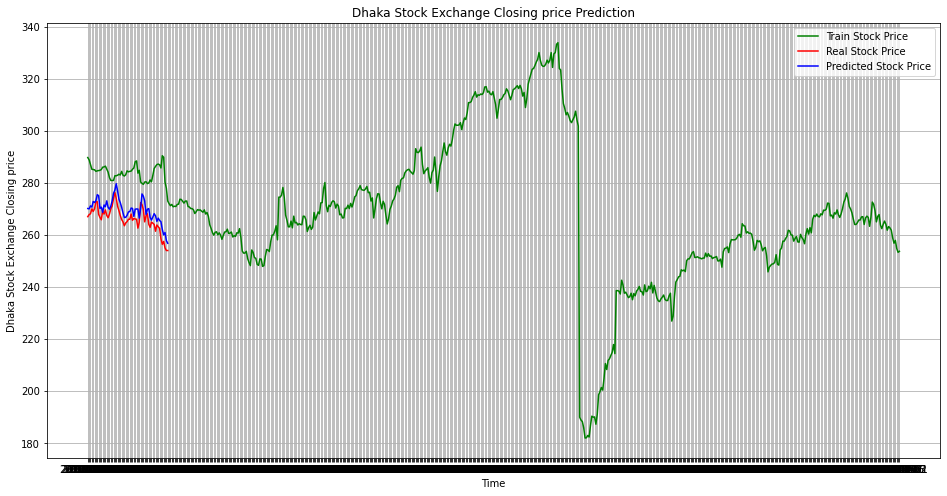

MSE: 14.870426958806798
MAE: 3.3816080729166638
RMSE: 3.856219257097137


In [98]:
plt.figure(figsize=(16,8))
plt.plot(df.index[-600:], df['closing_price'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, real_stock_price_GRU, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predicted_stock_price_GRU, color = 'blue', label = 'Predicted Stock Price')
plt.title('Dhaka Stock Exchange Closing price Prediction')
plt.xlabel('Time')
plt.ylabel('Dhaka Stock Exchange Closing price')
plt.legend()
plt.grid(True)
plt.savefig('lstm_30.pdf')
plt.show()

mse = mean_squared_error(real_stock_price_GRU, predicted_stock_price_GRU)
print('MSE: '+str(mse))
mae = mean_absolute_error(real_stock_price_GRU, predicted_stock_price_GRU)
print('MAE: '+str(mae))
rmse = sqrt(mean_squared_error(real_stock_price_GRU, predicted_stock_price_GRU))
print('RMSE: '+str(rmse))

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


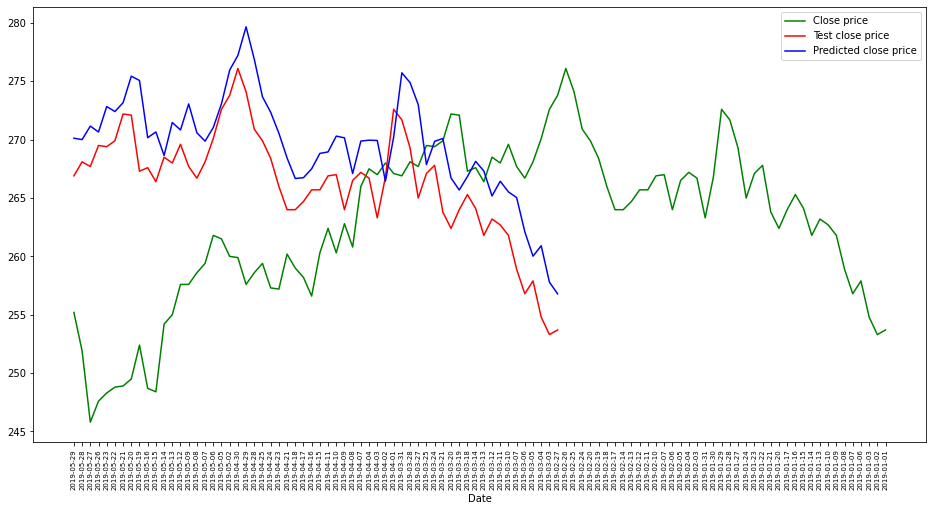

In [99]:
plt.figure(figsize=(16,8))
#print('Lag: %s' % model_fit.k_ar)
plt.plot(df.index[-100:], df['closing_price'].tail(100), color='green', label='Close price')
plt.plot(test_data.index, test_data['closing_price'], color='red', label='Test close price')
plt.plot(test_data.index, predicted_stock_price_GRU, color='blue', label='Predicted close price')
plt.xlabel('Date', fontsize=10)
plt.xticks(rotation=90,fontsize=7)
#plt.grid(True)
plt.legend()